## FP Analysis - Peak Detection
1. Date: Recording - 2024/05/15-16, Analysis - 2024/05/22-
2. Task: 3-Chamber test (E-E, S-E, S-S sessions)
3. Performer: Recording - YGKim, Analysis - YGKim
4. Animal: PV-Cre female and CHD8 WT/HT male 
5. Group, ID: as follows 

### 0. Import libraries

In [2]:
# import the libraries that we will use
import os
import pandas as pd
import numpy as  np
import pylab as plt
import seaborn as sns
from matplotlib.patches import Patch
from scipy.signal import medfilt, butter, filtfilt, find_peaks
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize

### 1. Set file parameters and working dir 
Put everything that should be sepecified by user.

In [3]:
Base_folder = r'C:/Users/YGKim_IBS/Documents/GitHub/Jupyter_notebook/FiberPhotometry' 
Batch_folder = '240522_PV-Cre' 
Animal_ID = 'PV_F_G01_003'
Session = 'EE'

FPS = 32 #Frame per second of behavior data
Duration_sec = 600 #Recording duration of behavior data
SavePlots = False
SaveData = False

Set working directory

In [4]:
cwd = os.path.join(Base_folder, Batch_folder, Animal_ID, Session)
if not os.path.exists(cwd):
        os.makedirs(cwd)
os.chdir(cwd)
os.getcwd()

'C:\\Users\\YGKim_IBS\\Documents\\GitHub\\Jupyter_notebook\\FiberPhotometry\\240522_PV-Cre\\PV_F_G01_003\\EE'

### 2. Load data-sets

In [5]:
#Load preprocessed data from Fiber photometry recording
GCaMP_signal = pd.read_pickle(os.path.join(os.getcwd(),"Final_table.pkl"))
time_sec = GCaMP_signal.time
signal_dF_F = GCaMP_signal.value
GCaMP_signal

,original_time,time,value
0,4.634050,0.000491,-2.865868
1,4.635034,0.001474,-2.862646
2,4.636017,0.002458,-2.859420
3,4.637000,0.003441,-2.856189
4,4.637983,0.004424,-2.852953
...,...,...,...
611162,605.430731,600.797172,-1.162749
611163,605.431714,600.798155,-1.162731
611164,605.432697,600.799138,-1.162712
611165,605.433680,600.800121,-1.162694


In [6]:
#Load postprocessed data from DeepLabCut analysis 
df_EVT = pd.read_csv('Data_DLC.csv', header=0, index_col=0)
df_EVT

,Nose_x,Nose_y,Head_x,Head_y,roi,transition_index,NHaxis_angle,Heading_2_Szone,distance,approaching,time_diff,x_bin,y_bin,EVT2,EVT3
0,541.744751,297.007263,541.744751,297.007263,else,NaN,300.063864,False,178.765570,False,0.0,158,58,NaN,NaN
1,543.343140,297.454956,543.343140,297.454956,else,NaN,298.409655,False,178.675633,True,1.0,159,58,NaN,NaN
2,543.771362,297.774078,543.771362,297.774078,else,NaN,300.319730,False,178.843220,False,1.0,159,58,NaN,NaN
3,545.617981,299.287781,545.617981,299.287781,else,NaN,296.787567,False,179.713405,False,1.0,160,58,NaN,NaN
4,545.617981,299.287781,545.617981,299.287781,else,NaN,302.201836,False,179.713405,False,1.0,160,58,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,580.108276,788.177002,580.108276,788.177002,E,NaN,261.725800,False,660.476612,False,1.0,170,154,NaN,NaN
19196,580.108276,788.662964,580.108276,788.662964,E,NaN,261.871317,False,660.962353,False,1.0,170,154,NaN,NaN
19197,581.821655,788.187866,581.821655,788.187866,E,NaN,263.289534,False,660.438090,True,1.0,170,154,NaN,NaN
19198,581.821655,787.740845,581.821655,787.740845,E,NaN,263.176704,False,659.991238,True,1.0,170,154,NaN,NaN


In [ ]:
df_EVT[df_EVT.EVT1==1.0]

### 3. Analysis & Statistical testing

#### 2-1. Peak detection
To detect peaks in the recorded signals, we will use find_peaks function in scipy.singal module which was already imported in our environment at the beginning. This function finds peaks inside a signal based on peak properties. For a successful peak detection, several parameters, such as height, threshold, distance, prominence, and width, should be specified by users.  

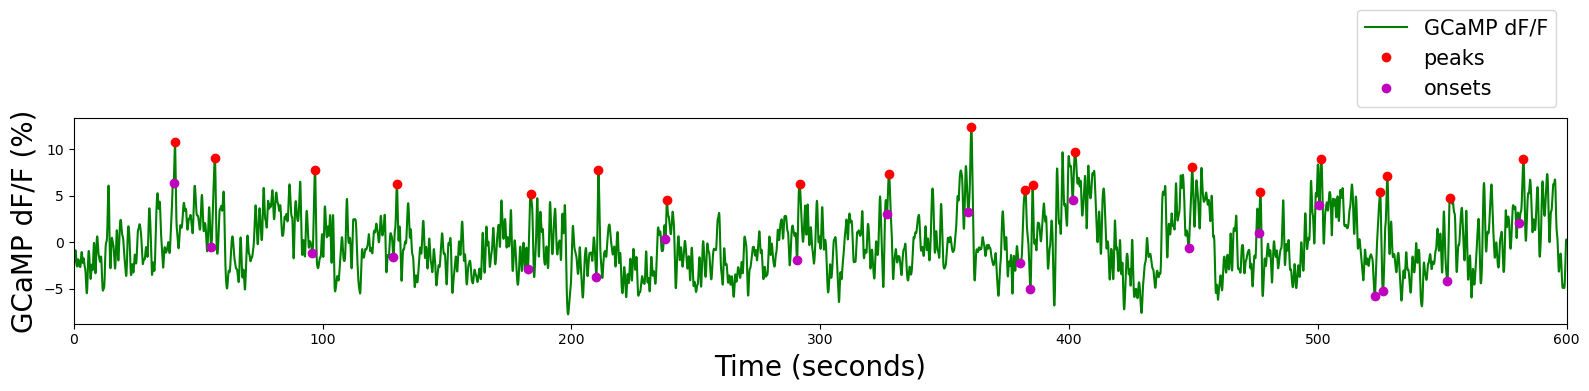

In [34]:
# Find peaks in the dFF signal using the scipy.signal.find_peaks() function
peaks, _ =find_peaks(x=signal_dF_F, prominence=10) #The prominence can be either 2 or 4.  
PeakNum = len(peaks)

# Function to find onset of the peak
def find_peak_onset(signal, peak_index, threshold=0.0005):
    onset_index = peak_index
    while onset_index > 0 and signal[onset_index] > signal[onset_index - 1] - threshold:
        onset_index -= 1
    return onset_index

# Find onset times for all peaks
onset_indices = [find_peak_onset(signal_dF_F, peak) for peak in peaks]

fig1 = plt.figure(figsize=(16,9))
ax1=fig1.add_subplot(311)
plot1=ax1.plot(time_sec, signal_dF_F, 'g', label='GCaMP dF/F')
Peaks = ax1.plot(time_sec[peaks], signal_dF_F[peaks], label = 'peaks', color = 'r', marker='o', ls ='')
Onsets = ax1.plot(time_sec[onset_indices], signal_dF_F[onset_indices], label='onsets', color = 'm', marker ='o', ls = "")

# ax1.set_ylim(-10, 15)
ax1.set_xlabel('Time (seconds)', fontsize =20)
ax1.set_ylabel('GCaMP dF/F (%)', color='k', fontsize = 20)

# ax1.set_title('Peak detection')
ax1.set_xlim(0, 600) # 초단위로 입력하여 x-axis zoom in 가능 

lines = plot1 + Peaks + Onsets
labels = [l.get_label() for l in lines]  #get legend labels
legend = ax1.legend(lines, labels, loc='lower right', bbox_to_anchor=(1, 1), fontsize = 15) #add legend

fig1.tight_layout()

if SavePlots == True:
    plt.savefig('Plot_Peak_detection.png')

In [36]:
# detected peaks에 대한 정보를 DataFrame으로 저장 
df_peaks = pd.DataFrame(data={'Peak_Index': peaks,
                              'Peak_X': np.array(time_sec[peaks]), 
                              'Peak_Y': np.array(signal_dF_F[peaks]),
                              'FrameForPeak': np.int64((time_sec[peaks])*FPS),
                              'Onset_Index': np.array(onset_indices),
                              'Onset_X': np.array(time_sec[onset_indices]),
                              'Onset_Y': np.array(signal_dF_F[onset_indices]),
                              'FrameForOnset': np.int64((time_sec[onset_indices])*FPS),
                              'OnsetLatency': np.subtract(np.array(time_sec[peaks]), np.array(time_sec[onset_indices])),
                              'Height': np.subtract(np.array(signal_dF_F[peaks]), np.array(signal_dF_F[onset_indices]))})

if SaveData == True:
    df_peaks.to_csv('Data_Peak_detection.csv', header=True)

df_peaks

,Peak_Index,Peak_X,Peak_Y,FrameForPeak,Onset_Index,Onset_X,Onset_Y,FrameForOnset,OnsetLatency,Height
0,41355,40.654110,10.768013,1300,40796,40.104590,6.368082,1283,0.549519,4.399931
1,57658,56.680611,9.044879,1813,56157,55.205068,-0.464035,1766,1.475543,9.508914
2,98596,96.924301,7.802582,3101,97547,95.893092,-1.180179,3068,1.031209,8.982762
3,132084,129.844344,6.285044,4155,130659,128.443512,-1.557579,4110,1.400832,7.842623
4,186759,183.592055,5.195765,5874,185580,182.433051,-2.839818,5837,1.159004,8.035583
5,214493,210.855686,7.727648,6747,213595,209.972916,-3.734924,6719,0.882770,11.462573
6,242491,238.378839,4.501761,7628,241879,237.777219,0.349692,7608,0.601620,4.152069
7,296723,291.691064,6.276876,9334,295675,290.660838,-1.944799,9301,1.030226,8.221675
8,333303,327.650666,7.332861,10484,332452,326.814099,3.035914,10458,0.836567,4.296947
9,366947,360.724063,12.372722,11543,365719,359.516890,3.275036,11504,1.207173,9.097686


In [ ]:
#위에서 찾은 peak들에 대해서 peak onset 1초 전부터 2초 후까지의 Ca2+ trace들을 추출하여 저장함. 
start_time_array = np.array(time_sec[onset_indices])

all_lines = []
start_time_list = []
end_time_list = []

for time in start_time_array:
    start_time = time-1
    end_time = time+2 
    filtered_data = np.array(GCaMP_signal.value[(time_sec >= start_time) & (time_sec <= end_time)].copy())

    all_lines.append(filtered_data)
    start_time_list.append(start_time)
    end_time_list.append(end_time)

all_lines = pd.DataFrame(all_lines)
all_lines_t = all_lines.transpose()
df_TimeWindow = pd.DataFrame({'start': start_time_list, 
                              'end': end_time_list})
all_lines_t.to_pickle(f'Data_Extraced_signal_of_detected_peaks.pkl')
df_TimeWindow.to_pickle(f'Data_TimeWindow_for_detected_peaks.pkl')


In [37]:
df_peaks['FrameForPeak']

0      1300
1      1813
2      3101
3      4155
4      5874
5      6747
6      7628
7      9334
8     10484
9     11543
10    12238
11    12331
12    12877
13    14383
14    15260
15    16043
16    16799
17    16892
18    17696
19    18643
Name: FrameForPeak, dtype: int64

In [39]:
df_EVT['Head_x'][df_peaks['FrameForPeak']]

1300     402.516327
1813     456.112152
3101     562.284180
4155     228.992828
5874     451.166718
6747     247.428665
7628     435.520935
9334     456.272400
10484    519.089050
11543    566.226440
12238    575.013611
12331    407.500519
12877    491.224304
14383    574.013794
15260    454.515839
16043    555.556702
16799    595.888184
16892    613.062073
17696    567.234436
18643    471.780579
Name: Head_x, dtype: float64

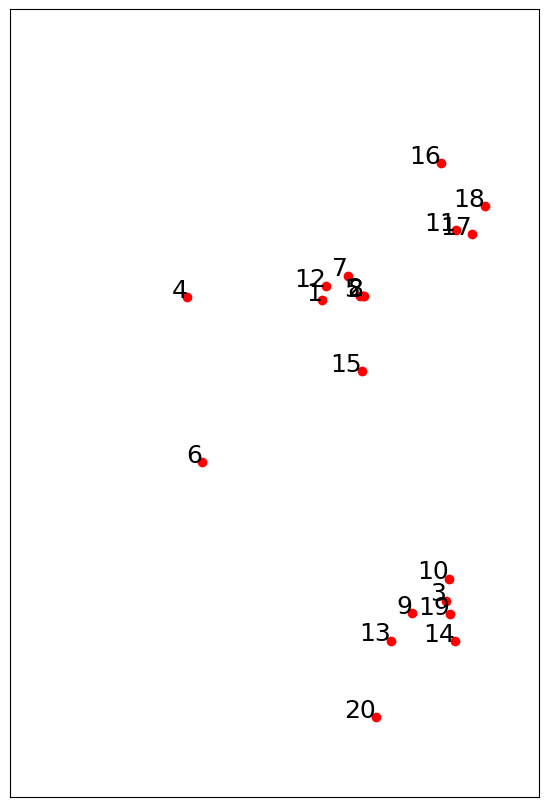

In [57]:
plt.figure(figsize=(6.82, 10.23))
data_x = df_EVT['Head_x'][df_peaks['FrameForPeak']]
data_y = df_EVT['Head_y'][df_peaks['FrameForPeak']] 

plt.scatter(data_x, data_y, color = 'red')

for i, (x, y) in enumerate(zip(data_x, data_y), start=1):
    plt.text(x, y, str(i), fontsize=18, ha='right')

plt.xlim(0, 682)
plt.ylim(1023, 0)

plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)